This notebook contains the code of the most similar atlas (SIM) approach 

In [2]:
# Import libraries
from pathlib import Path
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

from metadata import ImageDataset, patient

In [3]:
notebook_path = Path().cwd()
repo_path = notebook_path.parent
print(f'The current directory is: {notebook_path}')

The current directory is: d:\VS_Projects\MISA_FINAL_PROJECT\notebooks


In [4]:
#instantiate dataset, specify set name
img_training_data = ImageDataset('Training')
im_val_data = ImageDataset('Validation')

#check length
# print(f'len: {img_training_data.len}')
# #get all ids (useful to iterate over all adataset)
# print(f'all ids: {img_training_data.IDs}')
# #get list of all images paths for training
# print(f'images paths: {img_training_data.im_paths()}')
# #same for the labels
# print(f'images paths: {img_training_data.labels_paths()}')


#select one id of patient to check
id = img_training_data.IDs[0]
id_val = im_val_data.IDs[0]
print(f'selected id: {id}')
#istantiate patient object using the id and the previous ImageDataset object
pat = patient(id, img_training_data)
pat_val = patient(id_val, im_val_data)

# pat.show('labels')
# pat.show('im')

# Get the image and the labels
im = pat.im()
labels = pat.labels()

im_val = pat_val.im()
labels_val = pat_val.labels()

selected id: 01


In [5]:
def image_registration(fixedImage, movingImage):
    """Give two images and the registration of both, and its transformation map will be given

    Args:
        fixed_path (str): fixed (template) image
        moving_path (str): moving image (image that will be transformed)

    Returns:
        sitk image, transformix map: transformed image and the transformation map
    """

    #Start registration settings
    elastixImageFilter = sitk.ElastixImageFilter() #Image filter object
    #Defining settings
    elastixImageFilter.SetFixedImage(fixedImage)
    elastixImageFilter.SetMovingImage(movingImage)

    #Run registration
    elastixImageFilter.Execute()

    #Get result image
    resultImage = elastixImageFilter.GetResultImage()

    #Transformation map
    transformParameterMap = elastixImageFilter.GetTransformParameterMap()
    transformParameterMap[0]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    transformParameterMap[1]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]    
    transformParameterMap[2]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    return resultImage, transformParameterMap

### Registration and label propagation

  0%|          | 0/10 [00:00<?, ?it/s]

Registering training image 01 to validation image 11...


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1556\3729935244.py:32: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)
  0%|          | 0/10 [03:04<?, ?it/s]


IndexError: index 135 is out of bounds for axis 1 with size 128

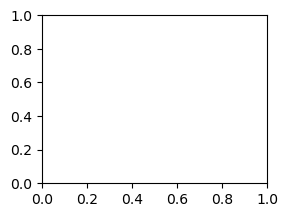

In [7]:
# for each training image, register it to the validation image
# add tqdm to see progress

list_labels = []
for i in tqdm(range(len(img_training_data.IDs))):
    id = img_training_data.IDs[i]
    pat = patient(id, img_training_data)
    moving_image = pat.im(preprocess=True)
    labels = pat.labels()

    for v in range(len(im_val_data.IDs)):

        id_val = im_val_data.IDs[v]

        print(f'Registering training image {id} to validation image {id_val}...')

        pat_val = patient(id_val, im_val_data)
        fixed_image = pat_val.im()
        labels_val = pat_val.labels()

        resultImage, transformParameterMap = image_registration(fixed_image, moving_image) #Resgiter images using predefined transform map

        transformixImageFilter = sitk.TransformixImageFilter() #Create object transform matrix
        transformixImageFilter.SetTransformParameterMap(transformParameterMap) #Set with found transform
        transformixImageFilter.SetMovingImage(labels_val) #set labels as moving
        transformixImageFilter.Execute() #Tranform labels

        labels_registered = transformixImageFilter.GetResultImage() #Propagated labels,

        # make the subplot of the moving image, fixed image and registered image, and propagated labels
        plt.title('Moving image, fixed image and registered image and propagated labels')
        plt.subplot(2,2,1)  
        plt.imshow(sitk.GetArrayFromImage(moving_image)[135], cmap='gray')
        plt.title('Moving image')
        plt.subplot(2,2,2)
        plt.imshow(sitk.GetArrayFromImage(fixed_image)[135], cmap='gray')
        plt.title('Fixed image')
        plt.subplot(2,2,3)
        plt.imshow(sitk.GetArrayFromImage(resultImage)[135], cmap='gray')
        plt.title('Registered image')
        plt.subplot(2,2,4)
        plt.imshow(sitk.GetArrayFromImage(labels_registered)[135], cmap='gray')
        plt.title('Propagated labels')
        plt.show()



        # with open(f'trans_labels.p', 'wb') as handle:   #Save propagated labels as pickle file
        #     pickle.dump(labels_registered, handle, pickle.HIGHEST_PROTOCOL)
            
        # list_labels.append(labels_registered) #Append all propagated labels on a list

# to save all the propagated labels in one file
# with open(f'all_trans_labels.p', 'wb') as handle: 
#     pickle.dump(list_labels, handle, pickle.HIGHEST_PROTOCOL)

### Make probablistic Atlas from propagated labels 